In [ ]:
import sys
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import subprocess

In [2]:
from matplotlib import rcParams
# Set global font to Helvetica
rcParams['font.family'] = 'DejaVu Sans' #'Helvetica'

In [3]:
from bfee import postTreatment

In [4]:
import py_bar

In [5]:
sys.path.append(os.getcwd())

In [6]:
# make results directory
results_dir = "results"
# if os.path.exists(results_dir):
#     print(f"Directory '{results_dir}' already exists. Exiting.")
#     return
os.makedirs(results_dir, exist_ok=True)

In [7]:
os.makedirs("plots", exist_ok=True)

In [8]:
temperature = 300 
unit = 'namd'
rigidLigand = False

post_treatment = postTreatment(temperature, unit)

In [9]:
def plot_pmf(file, cv):
    df = pd.read_csv(f'{file}', comment='#', header=None, sep=r'\s+')
    plt.plot(df[0], df[1])
    plt.xlabel(f'{cv}')
    plt.ylabel('PMF')
    plt.show()

In [10]:
def fepoutFile(filePath):

    Lambda = []
    dA_dLambda = []

    with open(filePath, 'r', encoding='utf-8') as fepoutFile:
        for line in fepoutFile.readlines():
            if not line.startswith('#Free energy'):
                continue
            splitedLine = line.strip().split()
            Lambda.append((float(splitedLine[7]) + float(splitedLine[8])) / 2)
            dA_dLambda.append(float(splitedLine[11]))

    if Lambda[0] > Lambda[1]:
        Lambda.reverse()
        dA_dLambda.reverse()

    return np.array((Lambda, np.cumsum(dA_dLambda)))

            
def results_fep(forwardFilePath, backwardFilePath, temperature = 300, jobType = 'bar'):
    """ parse a pair of fepout file, or a single double-wide file using the py_bar library

    Args:
        forwardFilePath (str): path to the forward fepout file
        backwardFilePath (str): path to the backward fepout file. Empty string
                                corresponds to a double-wide simulation
        temperature (float): temperature of the simulation
        jobType (str, optional): Type of the post-treatment method. 'fep' or 'bar'.
                                Defaults to 'fep'.
    Returns:
        tuple[float, float]: free-energy change, error
    """
    #results_forward = fepoutFile(forwardFilePath)
    #results_backward = fepoutFile(backwardFilePath)

    window, deltaU = py_bar.NAMDParser(forwardFilePath, backwardFilePath).get_data()
    analyzer = py_bar.FEPAnalyzer(window, deltaU, temperature)

    if jobType == 'bar':
        result = analyzer.BAR_free_energy(block_size=50, n_bootstrap=20)
    else:
        result = analyzer.FEP_free_energy()

    freeEnergy = np.sum(result[1])
    error = np.sqrt(np.sum(np.power(result[2], 2)))

    return freeEnergy, error


In [11]:
def alchemicalFreeEnergy(forwardFilePath, backwardFilePath = '', temperature = 300, jobType = 'fep'):
        """ parse a pair of fepout file, or a single double-wide file using the py_bar library

        Args:
            forwardFilePath (str): path to the forward fepout file
            backwardFilePath (str): path to the backward fepout file. Empty string
                                    corresponds to a double-wide simulation
            temperature (float): temperature of the simulation
            jobType (str, optional): Type of the post-treatment method. 'fep' or 'bar'.
                                      Defaults to 'fep'.
        Returns:
            tuple[float, float]: free-energy change, error
        """
        window, deltaU = py_bar.NAMDParser(forwardFilePath, backwardFilePath).get_data()
        analyzer = py_bar.FEPAnalyzer(window, deltaU, temperature)

        if jobType == 'bar':
            result = analyzer.BAR_free_energy(block_size=50, n_bootstrap=20)
        else:
            result = analyzer.FEP_free_energy()

        freeEnergy = np.sum(result[1])
        error = np.sqrt(np.sum(np.power(result[2], 2)))

        return freeEnergy, error

In [12]:
def results_ti(ti_log):
    Lambda = []
    dA_dLambda = []

    with open(f'{ti_log}_ti', 'w') as outfile:
        with open(ti_log, 'r', encoding='utf-8') as tiFile:
            for line in tiFile.readlines():
                if 'dA/dLambda' in line:
                    #outfile.write(line)
                    #outfile.write('\n')
                    
                    splitedLine = line.strip().split()
                    Lambda.append(float(splitedLine[4]))
                    dA_dLambda.append(float(splitedLine[6]))

    if Lambda[0] == Lambda[1]:
        correctedLambda = []
        correctedDA_dLambda = []

        
        numCVs = 7
        for i in range(0, len(Lambda), numCVs):
            correctedLambda.append(Lambda[i])
            totalDA_dLambda = 0
            for j in range(numCVs):
                totalDA_dLambda += dA_dLambda[i+j]
            correctedDA_dLambda.append(totalDA_dLambda)

        Lambda = correctedLambda
        dA_dLambda = correctedDA_dLambda
    
    if Lambda[0] > Lambda[1]:
        Lambda.reverse()
        dA_dLambda.reverse()

    data = np.vstack((Lambda, dA_dLambda)).T
    #np.savetxt(f'{ti_log}_ti', data, header="Lambda dA/dLambda", comments='', fmt='%.3f %.5f')

    for i in range(1, len(Lambda)):
        dA_dLambda[i] = (Lambda[i] - Lambda[i-1]) * dA_dLambda[i]

    results = np.array((Lambda, np.cumsum(dA_dLambda)))
    return results

In [13]:
def results_ti_bound(ti_log, direction):
    Lambda = []
    dA_dLambda = []
    numCVs = 7
    
    with open(ti_log, 'r', encoding='utf-8') as fepoutFile:
        for line in fepoutFile.readlines():
            if not ('dA/dLambda' in line):
                continue
            splitedLine = line.strip().split()
            Lambda.append(float(splitedLine[4]))
            dA_dLambda.append(float(splitedLine[6]))

    print(f'{direction} simulation')

    total_free_energy = []

    for j in range(numCVs):
        cv_Lambda = []
        cv_dA_dLambda = []
        for i in range(j, len(Lambda), numCVs):
            cv_Lambda.append(Lambda[i])
            cv_dA_dLambda.append(dA_dLambda[i])
        
        if direction == 'backward':
            cv_Lambda.reverse()
            cv_dA_dLambda.reverse()

        for i in range(1, len(cv_Lambda)):
            cv_dA_dLambda[i] = (cv_Lambda[i] - cv_Lambda[i-1]) * cv_dA_dLambda[i]

        result = (np.cumsum(cv_dA_dLambda))[-1]
        total_free_energy.append(result)

        print(f'Free energy difference cv {j} = {result}')

    free_energy_ti_bound = np.cumsum(total_free_energy)
    total_free_energy_ti_bound = free_energy_ti_bound[-1]

    print(f'TOTAL FREE ENERGY DIFFERENCE {direction} = {round(total_free_energy_ti_bound,3)}')
    return total_free_energy_ti_bound

In [14]:
def fepoutFile_combine(filePath):

    Lambda = []
    dA_dLambda = []

    with open(filePath, 'r', encoding='utf-8') as fepoutFile:
        for line in fepoutFile.readlines():
            if not line.startswith('#Free energy'):
                continue
            splitedLine = line.strip().split()
            Lambda.append(round((float(splitedLine[7]) + float(splitedLine[8])) / 2,4))
            dA_dLambda.append(round(float(splitedLine[11]),6))

        if Lambda[0] > Lambda[1]:
            Lambda.reverse()
            dA_dLambda.reverse()

        df_results = pd.DataFrame({'lambda': Lambda, 'dA': dA_dLambda})
        df_results.to_csv(f'{filePath}_all', index=None)

# Combine output files

In [ ]:
# fepout 

def sort_key(name):
    # num-first, then prioritize "long"
    n = int(re.findall(r'\d+', name)[0])
    is_long = 0 if "long" in name else 1
    return (n, is_long, name)

def extract_windows(lines):
    window_idxs = [i for i, l in enumerate(lines) if l.startswith("#NEW FEP WINDOW: LAMBDA SET TO")]
    if not window_idxs:
        raise ValueError("No windows found in the provided lines.")
    return window_idxs

def get_lambdas(line) -> tuple[str, str]:
    m = re.search(r"LAMBDA SET TO (\S+)\s+LAMBDA2 (\S+)", line)
    return (m.group(1), m.group(2)) if m else (None, None)

def partition_windows(lines):
    # returns (header, [(λ, start, end), ...]); λ := (lambda, lambda2)
    window_idxs = extract_windows(lines)
    header = lines[:window_idxs[0]]
    chunks = []
    for j, s in enumerate(window_idxs):
        e = window_idxs[j+1] if j+1 < len(window_idxs) else len(lines)
        chunks.append((get_lambdas(lines[s]), s, e))
    # for chunk in chunks:
    #     print(chunk[0])
    return header, chunks

def window_finished(chunk_lines):
    # accept only windows that end in a "#Free energy change ..." 
    for line in reversed(chunk_lines):
        if line.strip() == "":
            continue
        return line.startswith("#Free energy change")
    return False

def combine_fepouts():
    
    for step in ["001_MoleculeBound_longerbackwards3andforwards", "003_MoleculeUnbound"]:
        for direction in ["backward", "forward"]:
            seen = set()
            
            # get all fepouts
            print(f'\n{step}\t{direction}')
            fepout_files = sorted([f for f in os.listdir(f'BFEE/{step}/output') if f.endswith('.fepout') and direction in f], key=sort_key)
            print(fepout_files)

            # combine fepouts
            combined_lines = []
            header_written = False

            for fepout_file in fepout_files:
                with open(f'BFEE/{step}/output/{fepout_file}') as f:
                    lines = f.readlines()

                header, chunks = partition_windows(lines)
                if not header_written:
                    combined_lines.extend(header)
                    header_written = True

                for lam, s, e in chunks:
                    if not window_finished(lines[s:e]):
                        print(f"Skipping incomplete window {lam} in file {fepout_file}")
                        continue
                    if lam in seen:  # skip overlap
                        continue
                    combined_lines.extend(lines[s:e])
                    # print(f"Adding window {lam} from file {fepout_file}")
                    seen.add(lam)

            if not combined_lines or not combined_lines[-1].startswith("#Free energy change"):
                raise ValueError("Combined output does not end with '#Free energy change'")

            # validate that all windows are present
            print("Validating combined windows...")
            header, chunks = partition_windows(combined_lines)
            prev_lambda1, prev_lambda2 = None, None
            for chunk in chunks:
                lambda1, lambda2 = chunk[0]
                if prev_lambda1 is not None and prev_lambda2 is not None:
                    if lambda1 == prev_lambda1 and lambda2 == prev_lambda2:
                        raise ValueError(f"Duplicate window found for lambda {lambda1}, lambda2 {lambda2}")
                    if lambda1 != prev_lambda2:
                        raise ValueError(f"Missing window between (lambda1 {prev_lambda1}, lambda2 {prev_lambda2}) and (lambda1 {lambda1}, lambda2 {lambda2})")
                prev_lambda1, prev_lambda2 = lambda1, lambda2
            print(f"Validated {len(chunks)} combined windows.")

            base_name = re.sub(r'\d+', '', fepout_files[1].rsplit('.',1)[0]) 
            substep = "1" if direction == "backward" else "2"
            step_id = step.split("_")[0]
            out_name = f"{step_id}.{substep}_{base_name}_all.fepout"
            out_path = os.path.join(results_dir, out_name)
            with open(out_path, 'w') as out:
                out.writelines(combined_lines)
            print(f"Combined results written to {out_path}")
             
    return

combine_fepouts()


001_MoleculeBound_dblwindows	backward
['fep_backward1.fepout', 'fep_backward2.fepout', 'fep_backward3.fepout', 'fep_backward4.fepout', 'fep_backward5.fepout', 'fep_backward6.fepout']
Combined results written to results/001.1_fep_backward_all.fepout

001_MoleculeBound_dblwindows	forward
['fep_forward1.fepout', 'fep_forward2.fepout', 'fep_forward3.fepout', 'fep_forward4.fepout']
Combined results written to results/001.2_fep_forward_all.fepout

003_MoleculeUnbound	backward
['fep_backward1.fepout', 'fep_backward2.fepout']
Combined results written to results/003.1_fep_backward_all.fepout

003_MoleculeUnbound	forward
['fep_forward1.fepout', 'fep_forward2.fepout']
Combined results written to results/003.2_fep_forward_all.fepout


In [ ]:
# ti 

def combine_tilogs():
    
    for step in ["002_RestraintBound", "004_RestraintUnbound"]:
        for direction in ["backward", "forward"]:

            # get all tilogs
            print(f'\n{step}\t{direction}')
            tilog_files = sorted([f for f in os.listdir(f'BFEE/{step}') if f.endswith('.log') and direction in f])
            print(tilog_files)

            combined_lines = []
            # combine tilogs
            for tilog_file in tilog_files:
                with open(f'BFEE/{step}/{tilog_file}') as f:
                    lines = f.readlines()
                combined_lines.extend(lines)
           
            base_name = re.sub(r'\d+$', '', tilog_files[0].rsplit('.', 1)[0])
            out_name = f"{base_name}_all.log"
            out_path = os.path.join(results_dir, out_name)
            with open(out_path, 'w') as out:
                out.writelines(combined_lines)
            print(f"Combined results written to {out_path}")
            
            
combine_tilogs()


002_RestraintBound_dblsim	backward
['002.1_ti_backward1.log', '002.1_ti_backward2.log', '002.1_ti_backward3.log', '002.1_ti_backward4.log']
Combined results written to results/002.1_ti_backward_all.log

002_RestraintBound_dblsim	forward
['002.2_ti_forward1.log', '002.2_ti_forward2.log', '002.2_ti_forward3.log', '002.2_ti_forward4.log']
Combined results written to results/002.2_ti_forward_all.log

004_RestraintUnbound_dblsim	backward
['004.1_ti_backward1.log', '004.1_ti_backward2.log']
Combined results written to results/004.1_ti_backward_all.log

004_RestraintUnbound_dblsim	forward
['004.2_ti_forward1.log', '004.2_ti_forward2.log']
Combined results written to results/004.2_ti_forward_all.log


# 001: BOUND FEP

In [20]:
backward_fep_log = f'results/001.1_fep_backward_all.fepout'
forward_fep_log = f'results/001.2_fep_forward_all.fepout'

In [ ]:

vmd_output_dir = "results/vmd_output/1"

os.makedirs(vmd_output_dir, exist_ok=True)

tcl_script = f"""\
package require parsefep
parsefep -forward ../../../{forward_fep_log} -backward ../../../{backward_fep_log} -bar
"""

tcl_path = os.path.join(vmd_output_dir, "run_parsefep.tcl")
with open(tcl_path, "w") as f:
    f.write(tcl_script)

subprocess.run(
    "vmd -dispdev text -eofexit < run_parsefep.tcl > vmd.log",
    cwd=vmd_output_dir,
    check=True,
    shell=True,
)

CompletedProcess(args='vmd -dispdev text -eofexit < run_parsefep.tcl > vmd.log', returncode=0)

In [21]:
results_fep_bound_backward = fepoutFile(backward_fep_log)
results_fep_bound_forward = fepoutFile(forward_fep_log)

In [24]:
lambda_values_b, freeEnergyProfile_b = results_fep_bound_backward
lambda_values_f, freeEnergyProfile_f = results_fep_bound_forward

free_energy_fep_bound_backward = -freeEnergyProfile_b[-1]
free_energy_fep_bound_forward = freeEnergyProfile_f[-1]

print(f"Free Energy Change FEP backward: {free_energy_fep_bound_backward}")
print(f"Free Energy Change FEP forward: {free_energy_fep_bound_forward}")
print('\n')
free_energy_fep = round((free_energy_fep_bound_forward + free_energy_fep_bound_backward) / 2,5)
print(f"Free Energy Change FEP total: {free_energy_fep}")

Free Energy Change FEP backward: -54.30433883000001
Free Energy Change FEP forward: -53.832680270000004


Free Energy Change FEP total: -54.06851


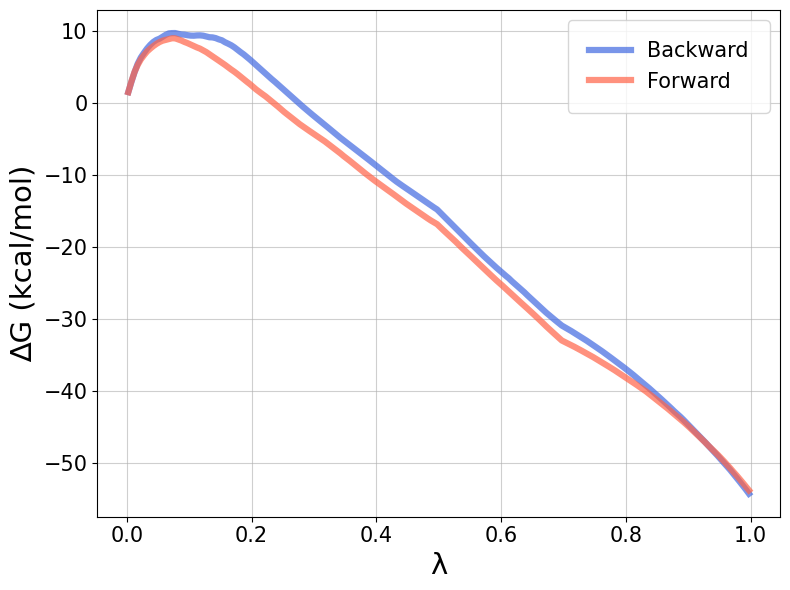

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(lambda_values_b, -freeEnergyProfile_b, color='royalblue', linewidth=4.5, alpha=0.7, label='Backward')
plt.plot(lambda_values_f, freeEnergyProfile_f, color='tomato', linewidth=4.5, alpha=0.7, label='Forward')

plt.xlabel('λ', fontsize=21)
plt.ylabel('∆G (kcal/mol)', fontsize=21)
#plt.title('Free Energy Profile', fontsize=16, fontweight='bold')

plt.legend(loc='best', fontsize=15, frameon=True, fancybox=True, borderpad=1)
plt.tick_params(axis='both', labelsize=15) 

plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.savefig("plots/fep_site.png", dpi=300, bbox_inches='tight')
plt.show()

In [26]:
#try with analyzer

In [27]:
free_energy_fep_bound, error_fep_bound = alchemicalFreeEnergy(forward_fep_log, backward_fep_log, 300, 'bar')

print(f"Free Energy Change FEP total: {free_energy_fep_bound} ± {error_fep_bound}")

Free Energy Change FEP total: -54.15305821849003 ± 0.03093552376247303


## Checking Convergence

In [ ]:
window, deltaU, deltaG, U_Lambda0, U_Lambda1 = py_bar.NAMDParser2(forward_fep_log, backward_fep_log).get_data() 

In [ ]:
# Checking dG over time
nwin = len(window)
fig, axes = plt.subplots(nwin, 1, figsize=(8, 3.0 * nwin), sharex=False)
step = 10

if nwin == 1:
    axes = [axes]
    
# compute global y-limits from deltaG (use forward and mapped backward)
# dlist = []
# for dg_f, dg_b in deltaG:
#     dlist.append(dg_f)
#     dlist.append(-dg_b)
# darr = np.hstack(dlist)
# ymin, ymax = float(darr.min()), float(darr.max())
# pad = 0.03 * (ymax - ymin) if ymax > ymin else 0.1
# ymin -= pad
# ymax += pad
# for a in axes:
#     a.set_ylim(ymin, ymax)
    
for i, ((lam0, lam1), (dg_f, dg_b)) in enumerate(zip(window, deltaG)):
    ax = axes[i]
    n_f = len(dg_f)
    n_b = len(dg_b)
    t_f = np.arange(n_f)
    t_b = np.arange(n_b)
    # plot forward ΔG (i→j) and backward mapped to i→j convention
    ax.plot(t_b[::step], -dg_b[::step], lw=0.8, label=f"-backward",color='royalblue')
    ax.plot(t_f[::step], dg_f[::step], lw=0.8, label=f"forward",color='tomato', alpha=0.8)
    ax.set_ylabel("ΔG")
    ax.set_title(f"λ {lam0:.3f} → {lam1:.3f}")
    ax.legend(loc="best", fontsize=8)
    ax.set_xlim(min(t_b[0], t_f[0]), max(t_b[-1], t_f[-1]))
    
    val1 = min(min(-dg_b[int(-0.25*len(dg_b)):-1]), min(dg_f[int(-0.25*len(dg_f)):-1]))
    val2 = max(max(-dg_b[int(-0.25*len(dg_b)): -1]), max(dg_f[int(-0.25*len(dg_f)): -1]))
    ax.set_ylim(min(val1,val2) - 0.1, max(val1,val2) + 0.1)
    
axes[-1].set_xlabel("Sample index")

fig.tight_layout()
fig.savefig("plots/dG_over_time.pdf", dpi=300, bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
# Checking U_l0 and U_l1 histogram overlap
def fd_bin_width(x):
    x = np.asarray(x).ravel()
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 1.0
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2 * iqr * (x.size ** (-1/3))
    if bw <= 0 or not np.isfinite(bw):
        raise ValueError("IQR-based bin width is non-positive or non-finite.")
    return bw if np.isfinite(bw) and bw > 0 else 1.0

nwin = len(window)
fig, axes = plt.subplots(nwin, 2, figsize=(12, 3.2 * nwin), sharex=False, sharey=False)
if nwin == 1:
    axes = np.array([axes])

for i, ((lam0, lam1), (U0_pair, U1_pair)) in enumerate(zip(window, zip(U_Lambda0, U_Lambda1))):
    U0_f, U0_b = U0_pair
    U1_f, U1_b = U1_pair

    # backward panel (left)
    axb = axes[i, 0]
    pooled_b = np.concatenate([U0_b[np.isfinite(U0_b)], U1_b[np.isfinite(U1_b)]])
    bw_b = fd_bin_width(pooled_b)
    min_b = np.floor(pooled_b.min()) if pooled_b.size else 0.0
    max_b = np.ceil(pooled_b.max()) if pooled_b.size else 1.0
    bins_b = np.arange(min_b, max_b + (bw_b / 2), bw_b)

    c0b, _ = np.histogram(U0_b, bins=bins_b)
    c1b, _ = np.histogram(U1_b, bins=bins_b)
    w_b = np.diff(bins_b)
    d0b = c0b / (U0_b.size * w_b) if U0_b.size else np.zeros_like(w_b)
    d1b = c1b / (U1_b.size * w_b) if U1_b.size else np.zeros_like(w_b)
    mids_b = bins_b[:-1] + 0.5 * w_b
    overlap_b = np.sum(np.minimum(d0b, d1b) * w_b) if (U0_b.size and U1_b.size) else np.nan
    axb.plot(mids_b, d0b, drawstyle="steps-mid", lw=1.0, label=f"U(λ={lam0:.3f})", color='darkblue')
    axb.plot(mids_b, d1b, drawstyle="steps-mid", lw=1.0, alpha=0.85, label=f"U(λ={lam1:.3f})", color='royalblue')
    axb.set_title(f"Backward — overlap {overlap_b*100:.1f}%", fontsize=10)
    axb.set_ylabel("density")
    axb.set_xlim(min_b, max_b)
    axb.legend(fontsize=8, loc="best")

    # forward panel (right)
    axf = axes[i, 1]
    pooled_f = np.concatenate([U0_f[np.isfinite(U0_f)], U1_f[np.isfinite(U1_f)]])
    bw_f = fd_bin_width(pooled_f)
    min_f = np.floor(pooled_f.min()) if pooled_f.size else 0.0
    max_f = np.ceil(pooled_f.max()) if pooled_f.size else 1.0
    bins_f = np.arange(min_f, max_f + (bw_f / 2), bw_f)

    c0f, _ = np.histogram(U0_f, bins=bins_f)
    c1f, _ = np.histogram(U1_f, bins=bins_f)
    w_f = np.diff(bins_f)
    d0f = c0f / (U0_f.size * w_f) if U0_f.size else np.zeros_like(w_f)
    d1f = c1f / (U1_f.size * w_f) if U1_f.size else np.zeros_like(w_f)
    mids_f = bins_f[:-1] + 0.5 * w_f
    overlap_f = np.sum(np.minimum(d0f, d1f) * w_f) if (U0_f.size and U1_f.size) else np.nan
    axf.plot(mids_f, d0f, drawstyle="steps-mid", lw=1.0, label=f"U(λ={lam0:.3f})", color='darkred')
    axf.plot(mids_f, d1f, drawstyle="steps-mid", lw=1.0, alpha=0.85, label=f"U(λ={lam1:.3f})", color='tomato')
    axf.set_title(f"Forward — overlap {overlap_f*100:.1f}%", fontsize=10)
    axf.set_xlim(min_f, max_f)
    axf.legend(fontsize=8, loc="best")

axes[-1, 0].set_xlabel("U (kcal/mol)")
axes[-1, 1].set_xlabel("U (kcal/mol)")
fig.tight_layout()
fig.savefig("plots/U_histograms.pdf", dpi=300, bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
# Checking dU overlap for forward and backward

def fd_bin_width(x):
    x = np.asarray(x).ravel()
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 1.0
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2 * iqr * (x.size ** (-1/3))
    if not np.isfinite(bw) or bw <= 0:
        std = np.std(x)
        bw = 3.5 * std * (x.size ** (-1/3))
    return 1.0 if (not np.isfinite(bw) or bw <= 0) else bw

nwin = len(window)
fig, axes = plt.subplots(nwin, 1, figsize=(10, 3.2 * nwin), sharex=False, sharey=False)
if nwin == 1:
    axes = [axes]
    
# compute global x-limits from deltaU (use forward and mapped backward)
dlist = []
for du_f, du_b in deltaU:
    dlist.append(du_f)
    dlist.append(-du_b)
darr = np.hstack(dlist)
xmin, xmax = float(darr.min()), float(darr.max())
pad = 0.03 * (xmax - xmin) if xmax > xmin else 0.1
xmin -= pad
xmax += pad
for a in axes:
    a.set_xlim(xmin, xmax)

for i, ((lam0, lam1), (du_f, du_b_raw)) in enumerate(zip(window, deltaU)):
    ax = axes[i]

    du_b = -np.asarray(du_b_raw, dtype=float)
    du_f = np.asarray(du_f, dtype=float)

    pooled = np.concatenate([du_f[np.isfinite(du_f)], du_b[np.isfinite(du_b)]])
    if pooled.size < 2:
        mids = np.array([0.0]); duf = np.array([0.0]); dub = np.array([0.0]); w = np.array([1.0])
        overlap = np.nan
    else:
        bw = fd_bin_width(pooled)
        xmin, xmax = np.floor(pooled.min()), np.ceil(pooled.max())
        bins = np.arange(xmin, xmax + (bw / 2), bw)
        w = np.diff(bins)
        mids = bins[:-1] + 0.5 * w

        c_f, _ = np.histogram(du_f, bins=bins)
        c_b, _ = np.histogram(du_b, bins=bins)

        duf = c_f / (du_f.size * w) if du_f.size else np.zeros_like(w)
        dub = c_b / (du_b.size * w) if du_b.size else np.zeros_like(w)

        overlap = float(np.sum(np.minimum(duf, dub) * w))

    ax.plot(mids, dub, drawstyle="steps-mid", lw=1.0, label="-backward", color="royalblue")
    ax.plot(mids, duf, drawstyle="steps-mid", lw=1.0, label="forward", color="tomato", alpha=0.85)
    
    # ax.axvline(0.0, lw=0.6, color="k", alpha=0.3)
    ax.set_ylabel("density")
    ax.set_title(f"λ {lam0:.3f} → {lam1:.3f} — overlap {overlap*100:.1f}%")
    ax.legend(fontsize=8, loc="best")

axes[-1].set_xlabel("ΔU")
fig.tight_layout()
fig.savefig("plots/dU_histograms.pdf", dpi=300, bbox_inches='tight', format='pdf')
plt.show()


# 002: BOUND TI

In [28]:
bound_ti_log_backward = f'results/002.1_ti_backward_all.log'
bound_ti_log_forward = f'results/002.2_ti_forward_all.log'

lambda = 0, 1, 0.01

In [29]:
results_ti_bound_backward = results_ti(bound_ti_log_backward)
results_ti_bound_forward = results_ti(bound_ti_log_forward)   

lambda_values_b, freeEnergyProfile_b = results_ti_bound_backward
lambda_values_f, freeEnergyProfile_f = results_ti_bound_forward

free_energy_ti_b = freeEnergyProfile_b[-1]
free_energy_ti_f = freeEnergyProfile_f[-1]

print(f"Free Energy Change TI backward: {free_energy_ti_b}")
print(f"Free Energy Change TI forward: {free_energy_ti_f}")

free_energy_ti_bound = -(free_energy_ti_f + free_energy_ti_b) / 2
error_ti_bound = abs((free_energy_ti_f - free_energy_ti_b) / 1.414)

print(f"Free Energy Change TI total: {free_energy_ti_bound} ± {error_ti_bound}")

Free Energy Change TI backward: 2.1211298615855205
Free Energy Change TI forward: 2.25345172962151
Free Energy Change TI total: -2.1872907956035155 ± 0.09357982180763044


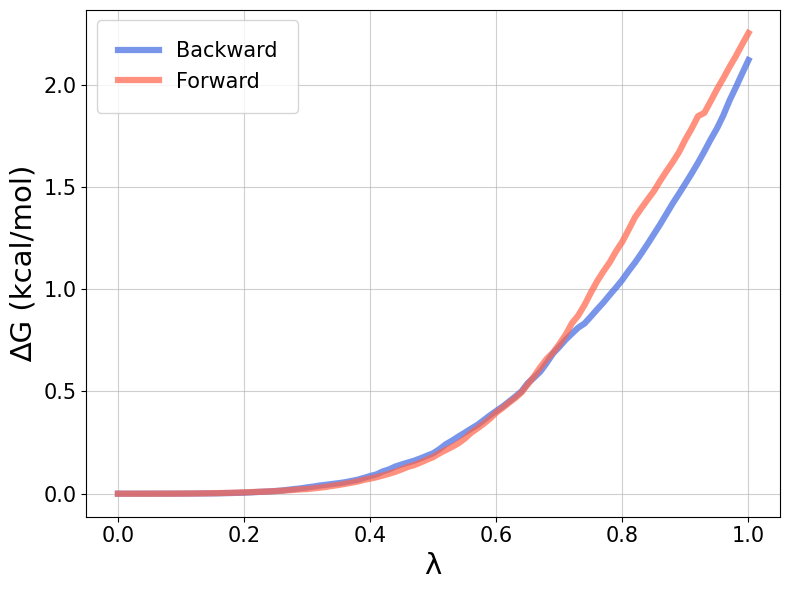

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(lambda_values_b, freeEnergyProfile_b, color='royalblue', linewidth=4.5, alpha=0.7, label='Backward')
plt.plot(lambda_values_f, freeEnergyProfile_f, color='tomato', linewidth=4.5, alpha=0.7, label='Forward')

plt.xlabel('λ', fontsize=21)
plt.ylabel('∆G (kcal/mol)', fontsize=21)
#plt.title('Free Energy Profile', fontsize=16, fontweight='bold')

plt.legend(loc='best', fontsize=15, frameon=True, fancybox=True, borderpad=1)
plt.tick_params(axis='both', labelsize=15) 

plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.savefig("plots/restraints_site.png", dpi=300, bbox_inches='tight')
plt.show()

In [31]:
results_ti_bound_backward = results_ti_bound(bound_ti_log_backward, 'backward')
results_ti_bound_forward = results_ti_bound(bound_ti_log_forward, 'forward')  

backward simulation
Free energy difference cv 0 = 0.4417902755887
Free energy difference cv 1 = 0.22116788058293
Free energy difference cv 2 = 0.2715021486995
Free energy difference cv 3 = 0.32254296462930004
Free energy difference cv 4 = 0.24575728698165006
Free energy difference cv 5 = 0.23889079124960003
Free energy difference cv 6 = 0.3794785138538398
TOTAL FREE ENERGY DIFFERENCE backward = 2.121
forward simulation
Free energy difference cv 0 = 0.5836878329977601
Free energy difference cv 1 = 0.2238723998797498
Free energy difference cv 2 = 0.26496913741610006
Free energy difference cv 3 = 0.3641230768022001
Free energy difference cv 4 = 0.24902955475339986
Free energy difference cv 5 = 0.26808915314430004
Free energy difference cv 6 = 0.29968057462799985
TOTAL FREE ENERGY DIFFERENCE forward = 2.253


# 003: Unbound FEP

In [32]:
unbound_fep_log_backward = f'results/003.1_fep_backward_all.fepout'
unbound_fep_log_forward = f'results/003.2_fep_forward_all.fepout'

In [33]:
results_fep_unbound_backward = fepoutFile(unbound_fep_log_backward)
results_fep_unbound_forward = fepoutFile(unbound_fep_log_forward)

In [34]:
lambda_values_b, freeEnergyProfile_b = results_fep_unbound_backward
lambda_values_f, freeEnergyProfile_f = results_fep_unbound_forward

free_energy_fep_unbound_backward = freeEnergyProfile_b[-1]
free_energy_fep_unbound_forward = -freeEnergyProfile_f[-1]

print(f"Free Energy Change FEP backward: {free_energy_fep_unbound_backward}")
print(f"Free Energy Change FEP forward: {free_energy_fep_unbound_forward}")
print('\n')
free_energy_fep = round((free_energy_fep_unbound_forward + free_energy_fep_unbound_backward) / 2,5)
print(f"Free Energy Change FEP total: {free_energy_fep}")

Free Energy Change FEP backward: 27.774383012999994
Free Energy Change FEP forward: 27.72927367899998


Free Energy Change FEP total: 27.75183


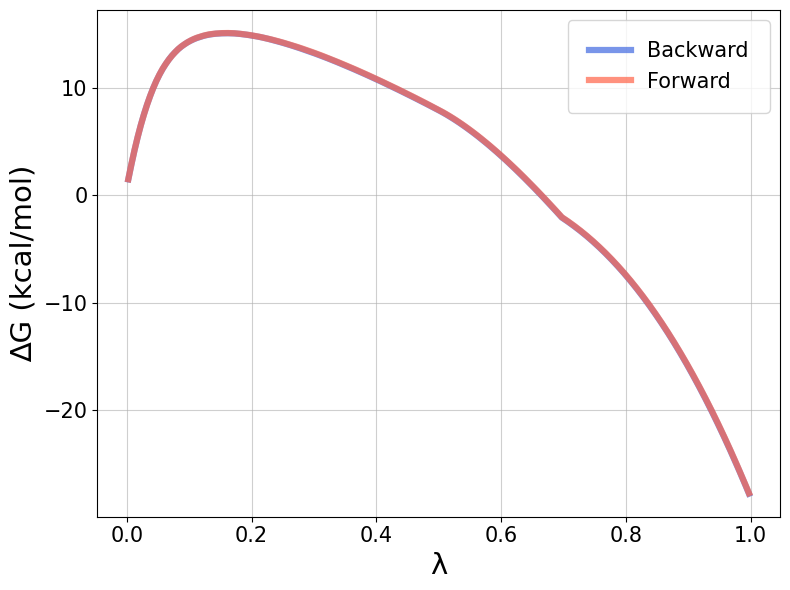

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(lambda_values_b, -freeEnergyProfile_b, color='royalblue', linewidth=4.5, alpha=0.7, label='Backward')
plt.plot(lambda_values_f, freeEnergyProfile_f, color='tomato', linewidth=4.5, alpha=0.7, label='Forward')

plt.xlabel('λ', fontsize=21)
plt.ylabel('∆G (kcal/mol)', fontsize=21)
#plt.title('Free Energy Profile', fontsize=16, fontweight='bold')

plt.legend(loc='best', fontsize=15, frameon=True, fancybox=True, borderpad=1)
plt.tick_params(axis='both', labelsize=15) 

plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.savefig("plots/fep_bulk.png", dpi=300, bbox_inches='tight')
plt.show()

In [36]:
free_energy_fep_unbound, error_fep_unbound = alchemicalFreeEnergy(unbound_fep_log_forward, unbound_fep_log_backward, 300, 'bar')
free_energy_fep_unbound = - free_energy_fep_unbound
print(f"Free Energy Change FEP total: {free_energy_fep_unbound} ± {error_fep_unbound}")

Free Energy Change FEP total: 27.743587931873627 ± 0.02303471068314092


# 004: Unbound TI

In [17]:
unbound_ti_log_backward = f'results/004.1_ti_backward_all.log'
unbound_ti_log_forward = f'results/004.2_ti_forward_all.log'

In [18]:
results_ti_unbound_backward = results_ti(unbound_ti_log_backward)
results_ti_unbound_forward = results_ti(unbound_ti_log_forward)   

lambda_values_b, freeEnergyProfile_b = results_ti_unbound_backward
lambda_values_f, freeEnergyProfile_f = results_ti_unbound_forward

free_energy_ti_b = freeEnergyProfile_b[-1]
free_energy_ti_f = freeEnergyProfile_f[-1]

print(f"Free Energy Change TI backward: {free_energy_ti_b}")
print(f"Free Energy Change TI forward: {free_energy_ti_f}")

free_energy_ti_unbound = (free_energy_ti_f + free_energy_ti_b) / 2
error_ti_unbound = abs((free_energy_ti_f - free_energy_ti_b) / 1.414)

print(f"Free Energy Change TI total: {free_energy_ti_unbound} ± {error_ti_unbound}")

Free Energy Change TI backward: 4.3761144713118005
Free Energy Change TI forward: 4.3517112529860515
Free Energy Change TI total: 4.363912862148926 ± 0.01725828735908698


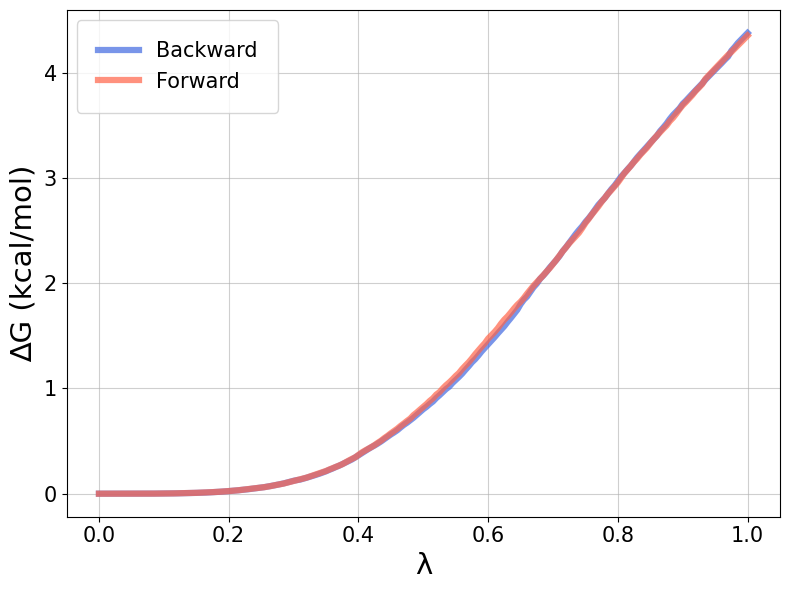

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(lambda_values_b, freeEnergyProfile_b, color='royalblue', linewidth=4.5, alpha=0.7, label='Backward')
plt.plot(lambda_values_f, freeEnergyProfile_f, color='tomato', linewidth=4.5, alpha=0.7, label='Forward')

plt.xlabel('λ', fontsize=21)
plt.ylabel('∆G (kcal/mol)', fontsize=21)
#plt.title('Free Energy Profile', fontsize=16, fontweight='bold')

plt.legend(loc='best', fontsize=15, frameon=True, fancybox=True, borderpad=1)
plt.tick_params(axis='both', labelsize=15) 

plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.savefig("plots/restraint_bulk.png", dpi=300, bbox_inches='tight')
plt.show()

In [37]:
def alchemicalRestraintContributionBulk(
    eulerTheta, polarTheta, R,
    forceConstantTheta=0.1, forceConstantPhi=0.1, forceConstantPsi=0.1,
    forceConstanttheta=0.1, forceConstantphi=0.1, forceConstantR=10
):
    """contribution of (standard concentration corrected) rotational
        and orienetational restraints in the unbounded state

    Args:
        eulerTheta (float): restraining center of the Euler angle theta
        polarTheta (float): restraining center of the polar angle theta
        R (float): restraining center of anger R
        forceConstantTheta (float): restraining force constant for euler Theta. Defaults to 0.1.
        forceConstantPhi (float, optional): restraining force constant for euler Phi. Defaults to 0.1.
        forceConstantPsi (float, optional): restraining force constant for euler Psi. Defaults to 0.1.
        forceConstanttheta (float, optional): restraining force constant for polar theta. Defaults to 0.1.
        forceConstantphi (float, optional): restraining force constant for polar phi. Defaults to 0.1.
        forceConstantR (int, optional): restraining force constant for distance R. Defaults to 10.

    Returns:
        float: contribution of the geometric restraint in the unbound state
    """

    BOLTZMANN = 0.0019872041
    CSTAR = 1661
    temperature = 300 

    # degrees to rad
    eulerTheta = math.radians(eulerTheta + 90)
    polarTheta = math.radians(polarTheta)
    forceConstantTheta *= (180 / math.pi)**2
    forceConstantPhi *= (180 / math.pi)**2
    forceConstantPsi *= (180 / math.pi)**2
    forceConstanttheta *= (180 / math.pi)**2
    forceConstantphi *= (180 / math.pi)**2

    contribution = BOLTZMANN * temperature * math.log(
        8 * (math.pi**2) * CSTAR / ((R**2) * math.sin(eulerTheta) * math.sin(polarTheta)) * \
        math.sqrt(forceConstantTheta * forceConstantPhi * forceConstantPsi * forceConstanttheta * \
        forceConstantphi * forceConstantR ) / ((2 * math.pi * BOLTZMANN * temperature)**3)
    )
    return contribution

In [ ]:
# analytical restraint contributions bulk
# Values from, say, 001_MoleculeBound/colvars.in

#deltaG_a_bulk = reorientation in bulk
free_energy_restraint_bulk = alchemicalRestraintContributionBulk(
    eulerTheta=-0.5, polarTheta=59.5, R=10.65,
    forceConstantTheta=0.1, forceConstantPhi=0.1, forceConstantPsi=0.1,
    forceConstanttheta=0.1, forceConstantphi=0.1, forceConstantR=10)

print(free_energy_restraint_bulk)

error_restraint_bulk = 0

11.253133922973435


# FINAL ALCHEMICAL FREE ENERGY DIFFERENCE

In [39]:
alchemial_free_energy_difference = free_energy_fep_bound + free_energy_ti_bound + free_energy_fep_unbound + free_energy_ti_unbound + free_energy_restraint_bulk
alchemial_error = math.sqrt(error_fep_bound**2 + error_ti_bound**2 + error_fep_unbound**2 + error_ti_unbound**2 + error_restraint_bulk**2)

print(f'alchemical free energy difference = {alchemial_free_energy_difference} ± {alchemial_error} kcal/mol')

alchemical free energy difference = -12.97971429709756 ± 0.10267733955859602 kcal/mol


In [40]:
# convert from DG to Kd

def convert_to_kd(free_energy, free_energy_err=None):
    """Convert free energy in kcal/mol to Kd in nM, with optional error propagation"""
    R = 0.0019872041  # kcal/(mol*K)
    T = 300  # K
    beta = 1 / (R * T)
    kd = math.exp(free_energy * beta) * 1e9  # nM
    
    # note that the error propagation is not really correct since the errors are not symmetric in the positive and negative direction
    # but this is a good approximation
    if free_energy_err is not None:
        kd_err = kd * beta * free_energy_err
        return kd, kd_err
    return kd

kd, kd_err = convert_to_kd(alchemial_free_energy_difference, alchemial_error)
print(f'Kd = {kd:.3g} ± {kd_err:.3g} nM')
kd_upper = convert_to_kd(alchemial_free_energy_difference + alchemial_error)
kd_lower = convert_to_kd(alchemial_free_energy_difference - alchemial_error)
print(f"Kd range = {kd_lower:.3g} to {kd_upper:.3g} nM")


Kd = 0.35 ± 0.0603 nM
Kd range = 0.295 to 0.416 nM
